# Mixture of Experts Forecasting

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import timedelta
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.metrics import mean_squared_error, mean_absolute_error



## Chronos Model Specification 

In [2]:
# Optional: helps avoid Hugging Face rate limits if you have a token set as env var
# os.environ["HUGGINGFACE_HUB_TOKEN"] = "<your_token_here>"


# Config

ITEM_ID = "humidity_series"
FREQ = "D"
ALPHA = 0.05            # 95% PI
CAL_SIZE = 60           # last N train points for calibration residuals
MODEL_REPO = "autogluon/chronos-bolt-small"  # change to ...-base if you want
LOCAL_MODEL_DIR = "models/chronos-bolt-small"


## Load Data and Do Some Feature Engineering Needed for Autogluon TimeSeries DataFrame

In [3]:

train = pd.read_csv("DailyDelhiClimateTrain.csv", parse_dates=["date"])[["date", "humidity"]].copy()
test  = pd.read_csv("DailyDelhiClimateTest.csv",  parse_dates=["date"])[["date", "humidity"]].copy()

# Add item_id BEFORE slicing to avoid SettingWithCopyWarning
train["item_id"] = ITEM_ID
test["item_id"]  = ITEM_ID

# Split calibration window from TRAIN (safe copies)
if CAL_SIZE >= len(train):
    raise ValueError("CAL_SIZE is larger than or equal to training length.")
train_main = train.iloc[:-CAL_SIZE].copy()
cal_df     = train.iloc[-CAL_SIZE:].copy()

# Wrap into AutoGluon TimeSeriesDataFrame
train_main_tsd = TimeSeriesDataFrame.from_data_frame(train_main, id_column="item_id", timestamp_column="date")
train_tsd      = TimeSeriesDataFrame.from_data_frame(train,      id_column="item_id", timestamp_column="date")

## Ensure model is available locally to avoid HF 429 error

In [4]:
def ensure_local_model(repo_id: str, local_dir: str) -> str:
    # If already present, use it; else snapshot_download
    if os.path.isdir(local_dir) and len(os.listdir(local_dir)) > 0:
        return local_dir
    try:
        from huggingface_hub import snapshot_download
        local = snapshot_download(
            repo_id=repo_id,
            local_dir=local_dir,
            local_dir_use_symlinks=False,   # safer on Windows
            # token=os.getenv("HUGGINGFACE_HUB_TOKEN") or None,
        )
        return local
    except Exception as e:
        print(f"[WARN] Could not download {repo_id} due to: {e}")
        print("[INFO] Falling back to repo path directly; may hit rate limits.")
        return repo_id  # fallback to remote path (AutoGluon will try to pull)

model_path = ensure_local_model(MODEL_REPO, LOCAL_MODEL_DIR)
hyperparams = {"Chronos": {"model_path": model_path}}

## Calibration: fit on train_main → forecast cal window → residual quantiles

In [5]:
pred_len_cal = len(cal_df)
predictor_cal = TimeSeriesPredictor(
    prediction_length=pred_len_cal,
    target="humidity",
    freq=FREQ,
    eval_metric="MSE",
    verbosity=1
)
predictor_cal.fit(train_data=train_main_tsd, hyperparameters=hyperparams, time_limit=None)

cal_forecast = predictor_cal.predict(train_main_tsd)
yhat_cal = cal_forecast.loc[(ITEM_ID, slice(None)), "mean"].to_numpy()
y_cal    = cal_df["humidity"].to_numpy()

resid_cal = y_cal - yhat_cal
q_low  = np.quantile(resid_cal, ALPHA/2)          # e.g., ~2.5th pct
q_high = np.quantile(resid_cal, 1 - ALPHA/2)      # e.g., ~97.5th pct


## Rolling forecast on TEST with prediction_length=1

In [6]:

predictor_roll = TimeSeriesPredictor(
    prediction_length=1,
    target="humidity",
    freq=FREQ,
    eval_metric="MSE",
    verbosity=1
)
predictor_roll.fit(train_data=train_tsd, hyperparameters=hyperparams, time_limit=None)

yhat_roll = []
context_pdf = train.copy()  # start with full training history

for d, y_obs in zip(test["date"].values, test["humidity"].values):
    # Rebuild TSD each step from the expanding context
    context_tsd = TimeSeriesDataFrame.from_data_frame(
        context_pdf, id_column="item_id", timestamp_column="date"
    )
    fcst = predictor_roll.predict(context_tsd)
    y_next = fcst.loc[(ITEM_ID, slice(None)), "mean"].to_numpy()[0]
    yhat_roll.append(y_next)

    # Append ACTUAL observation to context for next-step conditioning
    context_pdf = pd.concat(
        [context_pdf,
         pd.DataFrame({"date":[pd.to_datetime(d)], "humidity":[y_obs], "item_id":[ITEM_ID]})],
        ignore_index=True
    )

yhat_roll = np.array(yhat_roll)
y_true    = test["humidity"].to_numpy()
dates     = test["date"].to_numpy()


## Plot Actual Vs. Predicted Test Data and Prediction Interval

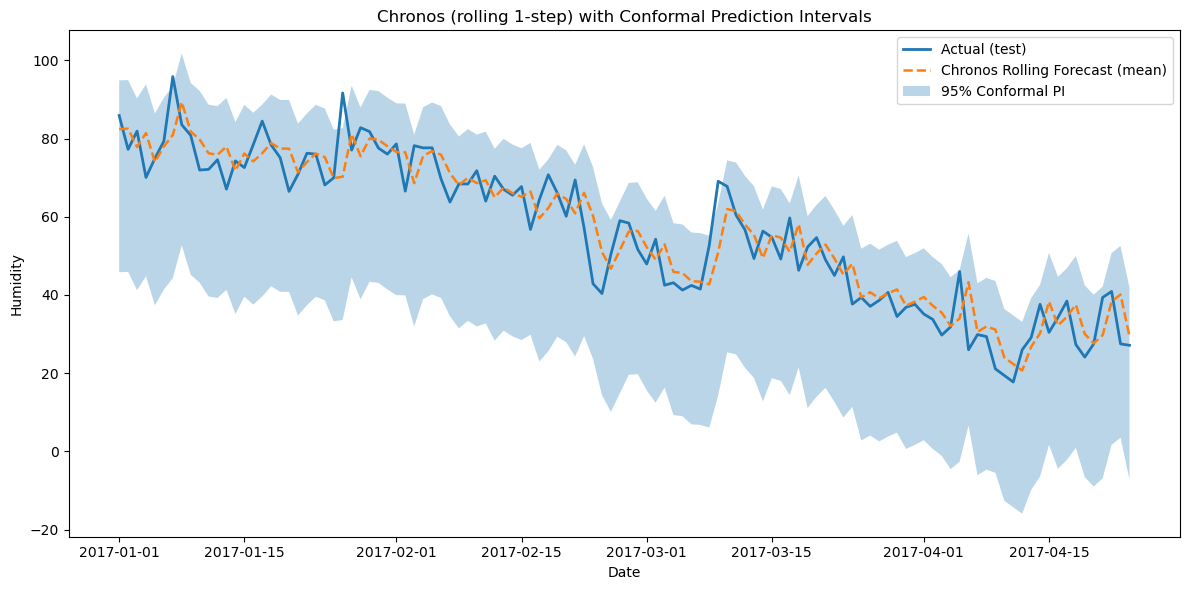

In [7]:
pi_lower = yhat_roll + q_low
pi_upper = yhat_roll + q_high

plt.figure(figsize=(12,6))
plt.plot(dates, y_true, label="Actual (test)", linewidth=2)
plt.plot(dates, yhat_roll, label="Chronos Rolling Forecast (mean)", linestyle="--", linewidth=1.8)
plt.fill_between(dates, pi_lower, pi_upper, alpha=0.3, label="95% Conformal PI")
plt.title("Chronos (rolling 1-step) with Conformal Prediction Intervals")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.legend()
plt.tight_layout()
plt.savefig("MixtureofExpertsPLOT.png")
plt.show()

## Compute Error Metrics and Coverage of Precision Interval

In [10]:

mse = mean_squared_error(y_true, yhat_roll)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, yhat_roll)
coverage = np.mean((y_true >= pi_lower) & (y_true <= pi_upper)) * 100.0

print(f"Chronos Rolling — MSE: {mse:.2f} |RMSE: {rmse:.2f}| MAE: {mae:.2f} | 95% PI coverage: {coverage:.2f}%")



Chronos Rolling — MSE: 45.52 |RMSE: 6.75| MAE: 5.18 | 95% PI coverage: 97.37%
